In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt

In [5]:
raw_train_data = pd.read_csv('./data/train.csv', index_col = 'PassengerId')
raw_test_data = pd.read_csv('./data/test.csv', index_col = 'PassengerId')

In [6]:
train_data = raw_train_data.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test_data = raw_test_data.drop(['Name', 'Ticket', 'Cabin'], axis=1)

Name, Ticket, Cabin Feature는 큰 의미가 없을것이라 판단.<br>
Column 삭제

------
**Feedback**<br>
®삭제하려면 삭제할 수 있는 근거가 있어야 한다.<br>
규칙이 없어 보여도 그 안에 무엇인가 있을 수 있음<br><br>

여기서 근거를 찾아보자

| Variable | 삭제 이유                                                    |
| -------- | ------------------------------------------------------------ |
| Name     | *Mrs, Miss, Mr* 가 있으므로 성별과 혼인 여부 알 수 있음.<br> 1. 성별 => **Sex** Feature<br>  2. 혼인한 사람중에 배우자가 같이 동승한 경우 => **Sibsp** Feature<br> 3. 혼인했는데 배우자가 동승하지 않은 경우 => 큰 의미 없다고 판단 |
| Ticket <br> Cabin   |  다 고유한 번호들로 느껴져서 안지울 수가 없음            |



In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


### Null 있는지 확인
'Age'에 177개 <br>
'Embarked'에 2개 null확인됬음. 


In [8]:
print(train_data['Age'].isnull().sum())
print(train_data['Embarked'].isnull().sum())

177
2



------
**Feedback**<br>
Fare를 잘 보면 0 값들이 있다(총 15개).<br>
이 사람들 무료로 탄걸까?<br>
아마 아니겠지. <br>
기록이 잘 안된거겠지. <br>
이 친구들도 채워 보자

In [9]:
train_data.loc[train_data.Fare == 0]['Fare'].count()

15

먼저 히스토그램 그려서 분포를 보자

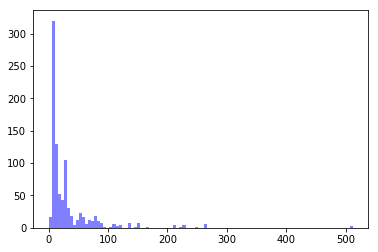

In [10]:
num_bins = 100
n, bins, patches = plt.hist(train_data['Fare'], num_bins, facecolor='blue', alpha=0.5)
plt.show()

Right Skewed 이 경우에는 Median이 더 Mode에 가까움. <br>
Median으로 채우자

In [11]:
change_median=train_data.Fare.replace({0: train_data['Fare'].median()})
(change_median==0).sum()

0

### Good!

### Value Counts for Categorical Data

In [12]:
category_list = ['Survived', 'Pclass', 'Sex', 'Embarked']
for i in category_list:
    print(i,' Value Counts')
    counts = train_data[i].value_counts()
    print(counts)
    if(counts.sum() != 891):
        print('This Data has', 891-counts.sum() ,'null value')
    print('---------------------')

Survived  Value Counts
0    549
1    342
Name: Survived, dtype: int64
---------------------
Pclass  Value Counts
3    491
1    216
2    184
Name: Pclass, dtype: int64
---------------------
Sex  Value Counts
male      577
female    314
Name: Sex, dtype: int64
---------------------
Embarked  Value Counts
S    644
C    168
Q     77
Name: Embarked, dtype: int64
This Data has 2 null value
---------------------


편향된 데이터가 있는지 체크<br>
잘 모르겠음.

In [13]:
train_data['Pclass'].value_counts().sum()

891

### Describe for Numerical Data

In [14]:
train_data[['Age', 'SibSp', 'Parch', 'Fare']].describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0xd21699fd0>,
      dtype=object)

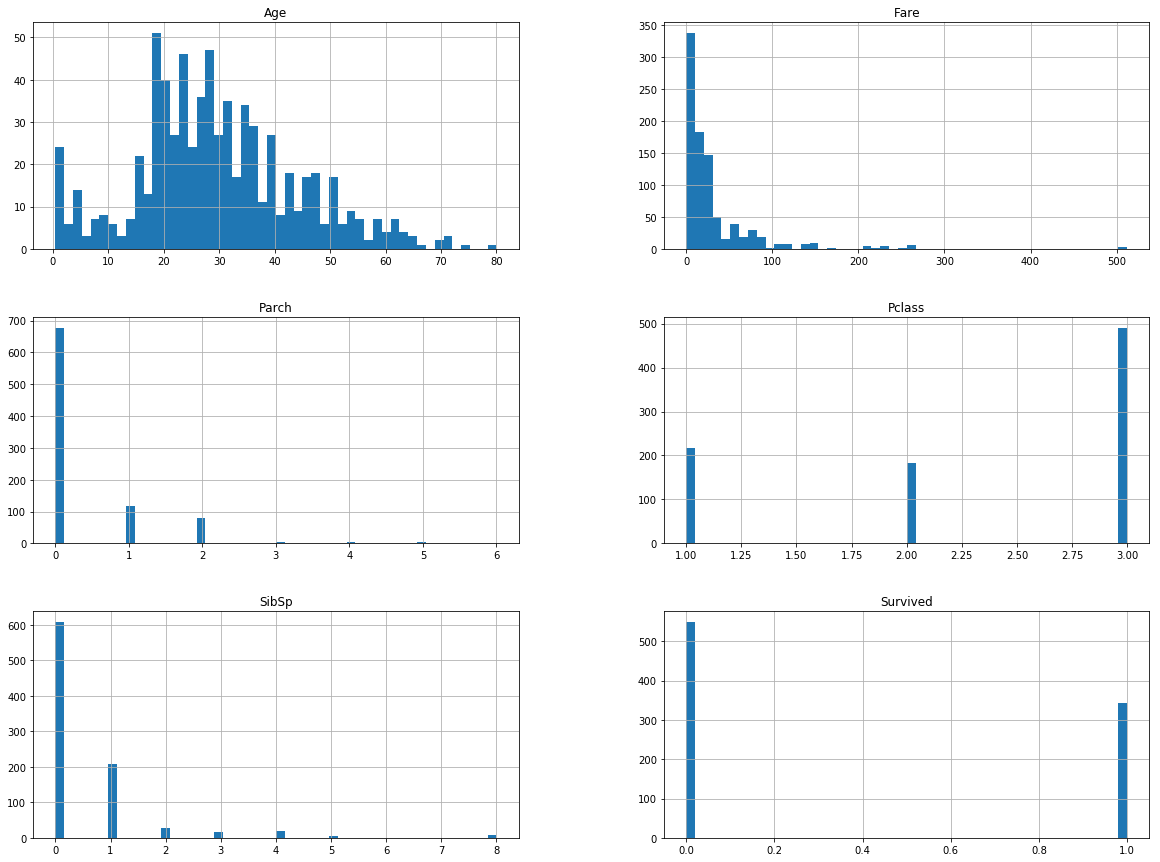

In [15]:
train_data.hist(bins=50, figsize=(20, 15))

### Correlation Coefficients

In [16]:
test_data.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.492143,0.001087,0.018721,-0.577147
Age,-0.492143,1.000000,-0.091587,-0.061249,0.337932
SibSp,0.001087,-0.091587,1.000000,0.306895,0.171539
Parch,0.018721,-0.061249,0.306895,1.000000,0.230046
Fare,-0.577147,0.337932,0.171539,0.230046,1.000000


In [17]:
len(train_data['Sex'].value_counts().index)

2

In [18]:
train_data_1=train_data
train_data_1['Sex']=train_data['Sex'].replace({'male':1 ,'female': 2})
train_data_1['Embarked']=train_data_1['Embarked'].replace({'C': 1, 'Q':2, 'S':3})

In [19]:
train_data_1.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307,-0.169718
Pclass,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500,0.164681
Sex,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333,-0.110320
Age,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.032565
SibSp,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651,0.068900
Parch,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225,0.040449
Fare,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000,-0.226311
Embarked,-0.169718,0.164681,-0.110320,-0.032565,0.068900,0.040449,-0.226311,1.000000



------
**Feedback**<br>
Correlation은 Continuous Value를 전제로 한다.<br>
Correlation을 계산해서 의미가 있으면 감을 잡을 순 있지만.<br>
그것을 어떤 *'객관적 근거'*로서 활용하기 에는 무리가 있다.<br>

현재<br>
'Survived', 'Pclass', 'Sex', 'Embarked' -> Categorical <br>
'Age', 'SibSp', 'Parch', 'Fare' -> Numerical But Discrete Value

어쨋든 Correlation 이 Sex와 Pclass가 높긴 해.

## Question
1. ***Correlation 은 Discrete일때도 객관적 근거가 될 수 없을까?***<br>
2. ***그럼 뭐가 객관적 근거가 되는 걸까?***<br>

In [20]:
train_data.groupby('Sex').sum()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
Sex,,,,,,,
1,109,1379,13919.17,248,136,14727.2865,1500.0
2,233,678,7286.00,218,204,13966.6628,754.0


In [21]:
#Number of non-null observations
train_data.groupby('Sex').count()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
Sex,,,,,,,
1,577,577,453,577,577,577,577
2,314,314,261,314,314,314,312


**Insight 1** 
여자는 대부분 살고 남자는 대부분 죽었음. 

In [22]:
train_data.groupby('Pclass').sum()['Survived'] / train_data.groupby('Pclass').count()['Survived']


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

**Insight 2** 
1등석이 확실히 더 많이 살았음.

In [23]:
train_data.groupby('Embarked').sum()['Survived'] / train_data.groupby('Embarked').count()['Survived']

Embarked
1.0    0.553571
2.0    0.389610
3.0    0.336957
Name: Survived, dtype: float64

**Insight 3** 
Cherbourg에서 승선한 사람은 50% 넘게 살았음 <br>
출구 쪽에 있었나?<br>
혹시 가장 마지막에 탑승했거나, 비상구에서 가까운 쪽에 위치하고 있었나?

In [24]:
print(train_data.groupby('SibSp').sum()['Survived'] / train_data.groupby('SibSp').count()['Survived'])
print(train_data.groupby('Parch').sum()['Survived'] / train_data.groupby('Parch').count()['Survived'])


SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64
Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64


이건 딱히 얻을게 있는지 잘 모르겠다. 

In [25]:
train_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000
mean,0.383838,2.308642,1.352413,29.699118,0.523008,0.381594,32.204208,2.535433
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.792088
min,0.000000,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,1.000000,20.125000,0.000000,0.000000,7.910400,2.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,3.000000
75%,1.000000,3.000000,2.000000,38.000000,1.000000,0.000000,31.000000,3.000000
max,1.000000,3.000000,2.000000,80.000000,8.000000,6.000000,512.329200,3.000000


In [26]:
bins = [x for x in range(-1, 81, 10)]

In [27]:
labels = [x for x in range(0, 8)]
print(labels)

[0, 1, 2, 3, 4, 5, 6, 7]


향후 New Features로 활용하게 편하게 <br>
0~9세: 0, 10~19세 : 1 <br>
이런식으로 세대 별로 매핑해서 Categorical Data로 만들었음. 

In [28]:
train_data_with_ages = train_data.copy()
train_data_with_ages['Age_Cut'] = pd.cut(train_data_with_ages['Age'], labels=labels,
                              bins=bins, include_lowest = True)
train_data_with_ages

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Cut
PassengerId,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,3.0,2.0
2,1,1,2,38.0,1,0,71.2833,1.0,3.0
3,1,3,2,26.0,0,0,7.9250,3.0,2.0
4,1,1,2,35.0,1,0,53.1000,3.0,3.0
5,0,3,1,35.0,0,0,8.0500,3.0,3.0
6,0,3,1,NaN,0,0,8.4583,2.0,NaN
7,0,1,1,54.0,0,0,51.8625,3.0,5.0
8,0,3,1,2.0,3,1,21.0750,3.0,0.0
9,1,3,2,27.0,0,2,11.1333,3.0,2.0


In [29]:
print(train_data_with_ages.groupby('Age_Cut').sum()['Survived'] / train_data_with_ages.groupby('Age_Cut').count()['Survived'])

Age_Cut
0    0.612903
1    0.401961
2    0.350000
3    0.437126
4    0.382022
5    0.416667
6    0.315789
7    0.000000
Name: Survived, dtype: float64


**나이대 별로 보면** 애기들이 확실히 더 많이 살았으니깐 <br>
이 상태로 다시 Correlation 체크 하자


In [30]:
int_cut = train_data_with_ages.Age_Cut.astype(float)

In [31]:
train_data_with_ages['Age_Cut']=int_cut

In [32]:
train_data_with_ages.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Cut
Survived,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307,-0.169718,-0.080072
Pclass,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500,0.164681,-0.349140
Sex,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333,-0.110320,-0.090459
Age,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.032565,0.980262
SibSp,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651,0.068900,-0.300555
Parch,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225,0.040449,-0.188898
Fare,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000,-0.226311,0.090733
Embarked,-0.169718,0.164681,-0.110320,-0.032565,0.068900,0.040449,-0.226311,1.000000,-0.040965
Age_Cut,-0.080072,-0.349140,-0.090459,0.980262,-0.300555,-0.188898,0.090733,-0.040965,1.000000


In [33]:
print(train_data_with_ages.groupby('Age_Cut').sum()['Survived'] / train_data_with_ages.groupby('Age_Cut').count()['Survived'])
print(train_data_with_ages.groupby('SibSp').sum()['Survived'] / train_data_with_ages.groupby('SibSp').count()['Survived'])
print(train_data_with_ages.groupby('Parch').sum()['Survived'] / train_data_with_ages.groupby('Parch').count()['Survived'])
print(train_data_with_ages.groupby('Embarked').sum()['Survived'] / train_data_with_ages.groupby('Embarked').count()['Survived'])

Age_Cut
0.0    0.612903
1.0    0.401961
2.0    0.350000
3.0    0.437126
4.0    0.382022
5.0    0.416667
6.0    0.315789
7.0    0.000000
Name: Survived, dtype: float64
SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64
Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64
Embarked
1.0    0.553571
2.0    0.389610
3.0    0.336957
Name: Survived, dtype: float64



------
**Feedback**<br>
확실히 Corrr값도 높게 나오는건, Pclass와 Sex<br>
그러나 Corr이 객관적 근거가 될 수 없다는 것  <=> Corr 이외 에도 객관적으로 유의한 지표들이 있을 수 있다는 것 <br>
Categorical데이터에 대해 추가적으로 찾아보면 <br>
***Age_Cut : 어린애들 많이 살았고,***<br>
***Embarked: 특정 위치에서 승선한 사람이 에서 더 많이 삼***<br>
조금 있다가 묶어서 더 분석 해보자. 

**1차적으로 가장 중요한 Feature는 Sex, Pclass**

In [34]:
train_data.groupby(['Sex', 'Pclass']).sum()['Survived'] / train_data.groupby(['Sex', 'Pclass']).count()['Survived']


Sex  Pclass
1    1         0.368852
     2         0.157407
     3         0.135447
2    1         0.968085
     2         0.921053
     3         0.500000
Name: Survived, dtype: float64

In [35]:
train_data.groupby(['Pclass', 'Sex']).sum()['Survived'] / train_data.groupby(['Pclass', 'Sex']).count()['Survived']

Pclass  Sex
1       1      0.368852
        2      0.968085
2       1      0.157407
        2      0.921053
3       1      0.135447
        2      0.500000
Name: Survived, dtype: float64

현재 여자가 Sex 2번, <br>
***여자 + 1등석 96.8% 생존***<br>
***여자 + 2등석 92.1% 생존***

In [36]:
pclass_sex = train_data.groupby(['Pclass', 'Sex']).sum()['Survived'] / train_data.groupby(['Pclass', 'Sex']).count()['Survived']

In [37]:
n_groups = 3
women_survived = []
men_survived= []
for i in range(1, 4):
    men_survived.append(pclass_sex[i][1])
    women_survived.append(pclass_sex[i][2])
    

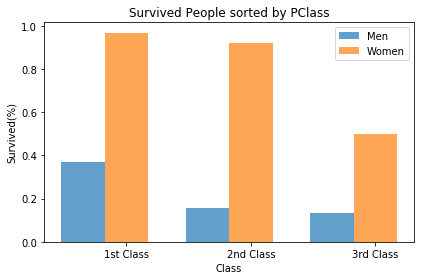

In [38]:

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.7
 
rects1 = plt.bar(index, men_survived, bar_width,
                 alpha=opacity,
                 label='Men')
 
rects2 = plt.bar(index + bar_width, women_survived, bar_width,
                 alpha=opacity,
                 label='Women')
 
plt.xlabel('Class')
plt.ylabel('Survived(%)')
plt.title('Survived People sorted by PClass')
plt.xticks(index + bar_width, ('1st Class', '2nd Class', '3rd Class'))
plt.legend()
 
plt.tight_layout()
plt.show()

In [39]:
sex_pclass= train_data.groupby(['Sex', 'Pclass']).sum()['Survived'] / train_data.groupby(['Sex', 'Pclass']).count()['Survived']


In [40]:
sex_pclass

Sex  Pclass
1    1         0.368852
     2         0.157407
     3         0.135447
2    1         0.968085
     2         0.921053
     3         0.500000
Name: Survived, dtype: float64

In [41]:
sex_list = ['male', 'female']

In [42]:
n_groups = 2
first_survived = []
second_survived= []
third_survived =[]
for i in [1, 2]:
    first_survived.append(sex_pclass[i][1])
    second_survived.append(sex_pclass[i][2])
    third_survived.append(sex_pclass[i][3])


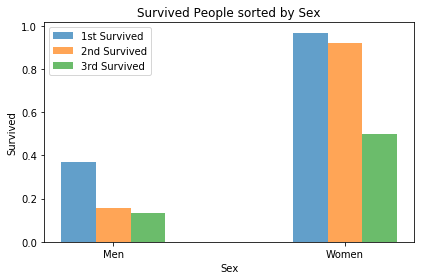

In [43]:
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.7
 
rects1 = plt.bar(index, first_survived, bar_width,
                 alpha=opacity,
                 label='1st Survived')
 
rects2 = plt.bar(index + bar_width, second_survived, bar_width,
                 alpha=opacity,
                 label='2nd Survived')
rects3 = plt.bar(index + bar_width+bar_width, third_survived, bar_width,
                 alpha=opacity,
                 label='3rd Survived')

 
plt.xlabel('Sex')
plt.ylabel('Survived')
plt.title('Survived People sorted by Sex')
plt.xticks(index + bar_width, ('Men', 'Women'))
plt.legend()
 
plt.tight_layout()
plt.show()

## 새로운 Feature 만들어 보자

일단 Pclass와 Sex를 기본으로<br>
아까 의심이 됬던 Age와 더불어 여러가지를 상상력으로 조합해 보자

In [44]:
train_data_with_new_features = train_data_with_ages.copy()

In [45]:
train_data_with_ages.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Cut
Survived,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307,-0.169718,-0.080072
Pclass,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500,0.164681,-0.349140
Sex,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333,-0.110320,-0.090459
Age,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.032565,0.980262
SibSp,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651,0.068900,-0.300555
Parch,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225,0.040449,-0.188898
Fare,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000,-0.226311,0.090733
Embarked,-0.169718,0.164681,-0.110320,-0.032565,0.068900,0.040449,-0.226311,1.000000,-0.040965
Age_Cut,-0.080072,-0.349140,-0.090459,0.980262,-0.300555,-0.188898,0.090733,-0.040965,1.000000


In [46]:
print(train_data_with_new_features.groupby(['Sex','SibSp']).sum()['Survived'])
print(train_data_with_new_features.groupby(['Sex','SibSp']).count()['Survived'])

Sex  SibSp
1    0         73
     1         32
     2          3
     3          0
     4          1
     5          0
     8          0
2    0        137
     1         80
     2         10
     3          4
     4          2
     5          0
     8          0
Name: Survived, dtype: int64
Sex  SibSp
1    0        434
     1        103
     2         15
     3          5
     4         12
     5          4
     8          4
2    0        174
     1        106
     2         13
     3         11
     4          6
     5          1
     8          3
Name: Survived, dtype: int64


In [47]:
print(train_data_with_new_features.groupby(['Age_Cut', 'Parch']).count()['Survived'])

Age_Cut  Parch
0.0      0          1
         1         35
         2         26
1.0      0         71
         1         15
         2         15
         3          1
2.0      0        187
         1         15
         2         15
         3          2
         4          1
3.0      0        136
         1         19
         2          8
         5          4
4.0      0         67
         1         14
         2          3
         3          1
         4          2
         5          1
         6          1
5.0      0         38
         1          8
         2          1
         3          1
6.0      0         15
         1          3
         4          1
7.0      0          5
         1          1
Name: Survived, dtype: int64


In [48]:
print(train_data_with_new_features.groupby(['Age_Cut','Parch']).sum()['Survived'] / train_data_with_new_features.groupby(['Age_Cut','Parch']).count()['Survived'])
print(train_data_with_new_features.groupby(['Parch','Age_Cut']).sum()['Survived'] / train_data_with_new_features.groupby(['Parch','Age_Cut']).count()['Survived'])

Age_Cut  Parch
0.0      0        1.000000
         1        0.657143
         2        0.538462
1.0      0        0.380282
         1        0.400000
         2        0.533333
         3        0.000000
2.0      0        0.304813
         1        0.533333
         2        0.666667
         3        1.000000
         4        0.000000
3.0      0        0.411765
         1        0.526316
         2        0.750000
         5        0.250000
4.0      0        0.373134
         1        0.571429
         2        0.333333
         3        0.000000
         4        0.000000
         5        0.000000
         6        0.000000
5.0      0        0.368421
         1        0.625000
         2        0.000000
         3        1.000000
6.0      0        0.333333
         1        0.333333
         4        0.000000
7.0      0        0.000000
         1        0.000000
Name: Survived, dtype: float64
Parch  Age_Cut
0      0.0        1.000000
       1.0        0.380282
       2.0        0.3

아니 근데 0~9세중에 Parch가 0인 1명은 대체 뭐지?<br>
근데 또 어떻게 다 살았지?<br>
지금 부모가 있는 자녀들이 더 많이 산건가?<br>
그걸 잘 모르겠음.<br>
근데 생각해보니깐 **꼬마들은 다 부모 있는거 아닌가?<br>
그럼 그게 0~9세 + Parch > 0 이 유의미한 변수라고 보기 힘들지 않나?**

In [49]:
train_data_with_new_features.groupby(['Sex','Pclass','Age_Cut']).sum()['Survived'] / train_data_with_new_features.groupby(['Sex','Pclass','Age_Cut']).count()['Survived']
train_data_with_new_features.groupby(['Embarked','Sex']).sum()['Survived'] / train_data_with_new_features.groupby(['Embarked','Sex']).count()['Survived']

Embarked  Sex
1.0       1      0.305263
          2      0.876712
2.0       1      0.073171
          2      0.750000
3.0       1      0.174603
          2      0.689655
Name: Survived, dtype: float64

In [50]:
print(train_data_with_new_features.groupby(['Age_Cut','Sex']).sum()['Survived'] / train_data_with_new_features.groupby(['Age_Cut','Sex']).count()['Survived']
     )
print(train_data_with_new_features.groupby(['Sex','Age_Cut']).sum()['Survived'] / train_data_with_new_features.groupby(['Sex','Age_Cut']).count()['Survived']
     )

Age_Cut  Sex
0.0      1      0.593750
         2      0.633333
1.0      1      0.122807
         2      0.755556
2.0      1      0.168919
         2      0.722222
3.0      1      0.214953
         2      0.833333
4.0      1      0.210526
         2      0.687500
5.0      1      0.133333
         2      0.888889
6.0      1      0.133333
         2      1.000000
7.0      1      0.000000
Name: Survived, dtype: float64
Sex  Age_Cut
1    0.0        0.593750
     1.0        0.122807
     2.0        0.168919
     3.0        0.214953
     4.0        0.210526
     5.0        0.133333
     6.0        0.133333
     7.0        0.000000
2    0.0        0.633333
     1.0        0.755556
     2.0        0.722222
     3.0        0.833333
     4.0        0.687500
     5.0        0.888889
     6.0        1.000000
Name: Survived, dtype: float64


### 상상력이 없나....

## Imagination

1. 여자면서 1st Class면 다 살았다고 해도 96%는 맞아(여자+2nd class도 92%는 맞아).
2. 일단 70대는 죽었다고 판단해도 될거 같아. → 구조원칙 상으로도 애기들부터 살린다네(근데 여자는 70대가 없음. 근데 50~60대가 거의 다삼. 쓰기 어려울듯)
3. 여자는 나이 대 별로 차이도 많이 안나고, 심지어 50~60대 여자들이 엄청나게 살았는데 남자는 
    나이대 까지 상관없이 그냥 거의 다 죽음

4. 남편이 같이 탄 여자? -> 찾아봤는데 딱히...
5. 부모 혹은 자녀가 있는 사람? → 찾아봤는데 딱히...


**여자 + 1st, 2nd Class라도 해서 하나 만들자**

In [51]:
sex_pclass_mask =(train_data_with_new_features['Sex']==2) & (train_data_with_new_features.Pclass !=  3) 
train_data_with_new_features['women_1st_2nd_class']=sex_pclass_mask.astype(float)

In [52]:
train_data_with_new_features.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Cut,women_1st_2nd_class
Survived,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307,-0.169718,-0.080072,0.562359
Pclass,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500,0.164681,-0.349140,-0.500673
Sex,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333,-0.110320,-0.090459,0.658233
Age,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.032565,0.980262,0.080084
SibSp,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651,0.068900,-0.300555,0.000230
Parch,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225,0.040449,-0.188898,0.085551
Fare,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000,-0.226311,0.090733,0.354893
Embarked,-0.169718,0.164681,-0.110320,-0.032565,0.068900,0.040449,-0.226311,1.000000,-0.040965,-0.090566
Age_Cut,-0.080072,-0.349140,-0.090459,0.980262,-0.300555,-0.188898,0.090733,-0.040965,1.000000,0.078868
women_1st_2nd_class,0.562359,-0.500673,0.658233,0.080084,0.000230,0.085551,0.354893,-0.090566,0.078868,1.000000


## Question
1. ***근데 만들었어도 어떻게 객관적으로 확인하지? 지금처럼 하면 되나?***<br>

현재까지! 

In [53]:
train_data_with_new_features

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Cut,women_1st_2nd_class
PassengerId,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,3.0,2.0,0.0
2,1,1,2,38.0,1,0,71.2833,1.0,3.0,1.0
3,1,3,2,26.0,0,0,7.9250,3.0,2.0,0.0
4,1,1,2,35.0,1,0,53.1000,3.0,3.0,1.0
5,0,3,1,35.0,0,0,8.0500,3.0,3.0,0.0
6,0,3,1,NaN,0,0,8.4583,2.0,NaN,0.0
7,0,1,1,54.0,0,0,51.8625,3.0,5.0,0.0
8,0,3,1,2.0,3,1,21.0750,3.0,0.0,0.0
9,1,3,2,27.0,0,2,11.1333,3.0,2.0,0.0


## Data Preprocessing For Maching Learning

#### 일단 Null값들 처리해야됨. 
null이 있었던 column은 총 2개 -> Age, Embarked

In [54]:
pre_train_data = train_data_with_new_features.copy()

In [55]:
pre_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
Survived               891 non-null int64
Pclass                 891 non-null int64
Sex                    891 non-null int64
Age                    714 non-null float64
SibSp                  891 non-null int64
Parch                  891 non-null int64
Fare                   891 non-null float64
Embarked               889 non-null float64
Age_Cut                713 non-null float64
women_1st_2nd_class    891 non-null float64
dtypes: float64(5), int64(5)
memory usage: 76.6 KB


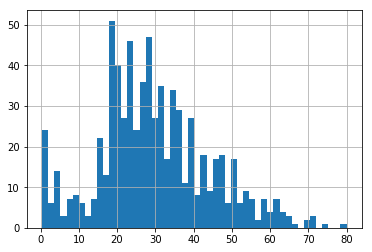

In [56]:
pre_train_data['Age'].hist(bins=50)

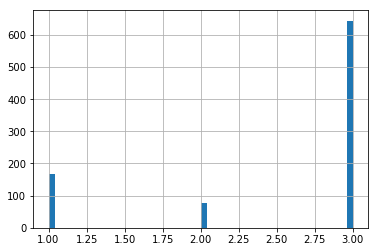

In [57]:
pre_train_data['Embarked'].hist(bins=50)

age에 null이 좀 많고, <br>
embarked에는 2개<br>
embarked row는 어쩔 수 없이 날려야 될 것 같고, <br>
**Age는 Right-Skewed -> Median으로 채우자**

In [58]:
pre_train_data = pre_train_data.dropna(subset=["Embarked"])

In [59]:
age_median = float(pre_train_data['Age'].median())
pre_train_data['Age'].fillna(age_median, inplace=True)

In [60]:
pre_train_data.index.drop

<bound method Index.drop of Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            882, 883, 884, 885, 886, 887, 888, 889, 890, 891],
           dtype='int64', name='PassengerId', length=889)>

In [61]:
pre_train_data = pre_train_data.reset_index(drop=True)

In [62]:
train_y = pd.DataFrame(pre_train_data['Survived'])
train_x = pre_train_data.drop(['Survived'], axis=1)

One-Hot Encoding<br>
Y - Survived <br>
X - pclasss, sex, embarked를 one-hot encoding 해야 함. 

In [63]:
pclass_encoded = pd.get_dummies(train_x['Pclass'])
sex_encoded = pd.get_dummies(train_x['Sex'])
embarked_encoded = pd.get_dummies(train_x['Embarked'])
y_encoded = pd.get_dummies(train_y['Survived'])

In [64]:
train_x_encoded = train_x.drop(['Pclass', 'Embarked', 'Sex'],axis=1)
train_y_encoded = y_encoded

In [65]:
train_x_encoded = pd.concat([train_x_encoded ,pclass_encoded, sex_encoded, embarked_encoded], axis=1)

In [66]:
print(train_x_encoded)

      Age  SibSp  Parch      Fare  Age_Cut  women_1st_2nd_class  1  2  3  1  \
0    22.0      1      0    7.2500      2.0                  0.0  0  0  1  1   
1    38.0      1      0   71.2833      3.0                  1.0  1  0  0  0   
2    26.0      0      0    7.9250      2.0                  0.0  0  0  1  0   
3    35.0      1      0   53.1000      3.0                  1.0  1  0  0  0   
4    35.0      0      0    8.0500      3.0                  0.0  0  0  1  1   
5    28.0      0      0    8.4583      NaN                  0.0  0  0  1  1   
6    54.0      0      0   51.8625      5.0                  0.0  1  0  0  1   
7     2.0      3      1   21.0750      0.0                  0.0  0  0  1  1   
8    27.0      0      2   11.1333      2.0                  0.0  0  0  1  0   
9    14.0      1      0   30.0708      1.0                  1.0  0  1  0  0   
10    4.0      1      1   16.7000      0.0                  0.0  0  0  1  0   
11   58.0      0      0   26.5500      5.0          

Age_Cut은 Nan값을 채우기 전에 만든 것임으로<br>
Age가 NaN이였던 Row의 Age_Cut은 아직도 NaN임.<br>
그 친구들 채워야 함

In [67]:
train_data_with_ages = train_x_encoded.copy()
train_x_encoded['Age_Cut'] = pd.cut(train_data_with_ages['Age'], labels=labels,
bins=bins, include_lowest = True)

train_x_encoded['Age_Cut'] = train_x_encoded['Age_Cut'].astype(float) 

In [68]:
train_x_encoded[train_x_encoded['Age_Cut'].isnull()]

,Age,SibSp,Parch,Fare,Age_Cut,women_1st_2nd_class,1,2,3,1,2,1.0,2.0,3.0
629,80.0,0,0,30.0,NaN,0.0,1,0,0,1,0,0,0,1


In [69]:
train_x_encoded[train_x_encoded['Age_Cut'].isnull()]=80

In [70]:
train_x_encoded[train_x_encoded['Age_Cut'].isnull()]

,Age,SibSp,Parch,Fare,Age_Cut,women_1st_2nd_class,1,2,3,1,2,1.0,2.0,3.0


In [71]:
train_x_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 14 columns):
Age                    889 non-null float64
SibSp                  889 non-null int64
Parch                  889 non-null int64
Fare                   889 non-null float64
Age_Cut                889 non-null float64
women_1st_2nd_class    889 non-null float64
1                      889 non-null uint8
2                      889 non-null uint8
3                      889 non-null uint8
1                      889 non-null uint8
2                      889 non-null uint8
1.0                    889 non-null uint8
2.0                    889 non-null uint8
3.0                    889 non-null uint8
dtypes: float64(4), int64(2), uint8(8)
memory usage: 48.7 KB


In [72]:
train_x_encoded['SibSp'] = train_x_encoded['SibSp'].astype(float) 
train_x_encoded['Parch'] = train_x_encoded['Parch'].astype(float) 

#### Feature Scaling
Age, Fare, SibSp, Parch, Age_Cut을 Scaling 할 것<br>
stdscaler or MinMax Scaler?

In [73]:
from sklearn.preprocessing import StandardScaler

In [74]:
stdscaler = StandardScaler()

In [75]:
before_scaler = train_x_encoded[['Age', 'Fare', 'SibSp', 'Parch', 'Age_Cut']]

In [76]:
after_scaler = pd.DataFrame(stdscaler.fit_transform(before_scaler),
             columns=before_scaler.columns)

In [77]:
drop_x= train_x_encoded.drop(['Age', 'Fare', 'SibSp', 'Parch'],
                                                 axis= 1)

In [78]:
train_x_scaled = pd.concat([after_scaler, drop_x], axis = 1)

In [79]:
train_x_scaled.shape

(889, 15)

train x : train_x_scaled<br>
train y : train_y_encoded

In [80]:
X = train_x_scaled.values
y = train_y.values.flatten()


------
**Feedback**<br>
***Ground Truth***<br>
Accuracy를 구하려면 최소 하나로 몰빵 예측했을때 보다는 높아야 함.

In [81]:
print(sum(y==1)/len(y))

0.38245219347581555


In [82]:
print(sum(y==0)/len(y))

0.6175478065241845


다 살았다고 예측하면 38% 맞고, 다 죽었다고 예측하면 61% 맞음.<br>


# Logitstic Regression

In [83]:
from sklearn.model_selection import cross_val_score

In [84]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [85]:
scores = cross_val_score(log_reg, X, y, cv=10)
print(scores)
print("mean: ", np.mean(scores))
print("Standard Deviation: ", np.std(scores))

[0.79775281 0.79775281 0.76404494 0.83146067 0.83146067 0.79775281
 0.82022472 0.79775281 0.84269663 0.82954545]
mean:  0.811044433094995
Standard Deviation:  0.022754546448635508


### Accuracy 81%

### Softmax

In [84]:
solver_list = ['lbfgs','sag', 'saga']

In [85]:
for i in solver_list:
    softmax_reg = LogisticRegression(multi_class="multinomial", solver=i, C=10)
    softmax_reg.fit(X, y)
    scores = cross_val_score(softmax_reg, X, y, cv=10)
    print('solver', i, ' scores')
    print("mean: ", np.mean(scores))
    print("Standard Deviation: ", np.std(scores))

solver lbfgs  scores
mean:  0.809920837589377
Standard Deviation:  0.024171258578039777


/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The ma

solver sag  scores
mean:  0.7952885597548518
Standard Deviation:  0.03712458015700324


/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The ma

solver saga  scores
mean:  0.7874106230847804
Standard Deviation:  0.04242513819923914


/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Accuracy 79~81%

# Support Vector Machine

### Linear SVM Classifier

In [86]:
from sklearn.svm import LinearSVC

In [87]:
c_dict = {}
for i in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    linear_svc =LinearSVC(C =i, loss="hinge")
    linear_svc.fit(X, y)
    scores = cross_val_score(linear_svc, X, y, cv=10)
    c_dict[i]=np.mean(scores)
    
print(c_dict)    
for key, value in c_dict.items():
    if value == max(c_dict.values()):
        print("The Best C value is", key)
        print("The rmse of C=", key, "is ", value)

{0.001: 0.6838993871297241, 0.01: 0.7873723186925434, 0.1: 0.7952374872318693, 1: 0.7817671092951991, 10: 0.7851506639427988, 100: 0.7660495403472931, 1000: 0.6904494382022472}
The Best C value is 0.1
The rmse of C= 0.1 is  0.7952374872318693


In [88]:
c_dict = {}
for i in [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.9, 1]:
    linear_svc =LinearSVC(C =i, loss="hinge")
    linear_svc.fit(X, y)
    scores = cross_val_score(linear_svc, X, y, cv=10)
    c_dict[i]=np.mean(scores)
    
print(c_dict)    
for key, value in c_dict.items():
    if value == max(c_dict.values()):
        print("The Best C value is", key)
        print("The rmse of C=", key, "is ", value)

{0.001: 0.6838993871297241, 0.005: 0.7941138917262512, 0.01: 0.7873723186925434, 0.05: 0.7873723186925434, 0.1: 0.7952374872318693, 0.3: 0.7873723186925434, 0.9: 0.7828907048008171, 1: 0.7828907048008171}
The Best C value is 0.1
The rmse of C= 0.1 is  0.7952374872318693


------
**Feedback**<br>
1, 10, 100 이런식으로 넓은 범위의 값들을 먼저 대입 → 값을 돌리고 차이를 살핀다.<br>
그래프가 어떻게 나오는지 보고, Skewed된 그래프 쪽으로 점차 값을 줄여 간다.<br>
한번에 500개씩 넣고 할 필요가 없음. 범위를 점점 좁히는 작업.

### Accuracy 79%

### Non-Linear SVM Classifier

In [91]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [92]:
p_dict ={}

for i in list([2, 3, 4]):
    poly_features = PolynomialFeatures(degree=i)
    x_poly = poly_features.fit_transform(X)
    
    for j in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        linear_svc = LinearSVC(C =j, loss="hinge")
        linear_svc.fit(x_poly, y)
        scores = cross_val_score(linear_svc, x_poly,y, cv=10)
        p_dict[i, j]=np.mean(scores)
        #i= degree, j=C
                
print(p_dict)    
for key, value in p_dict.items():
    if value == max(p_dict.values()):
        print("The Best C value is", key[1])
        print("The Best Degree value is", key[0])
        print("The score is ", value)            

{(2, 0.001): 0.7997574055158324, (2, 0.01): 0.8110188968335036, (2, 0.1): 0.8301583248212461, (2, 1): 0.8256639427987743, (2, 10): 0.8043283963227783, (2, 100): 0.7447522982635342, (2, 1000): 0.7389427987742595, (3, 0.001): 0.8144024514811031, (3, 0.01): 0.827885597548519, (3, 0.1): 0.8054647599591419, (3, 1): 0.7907814096016343, (3, 10): 0.7095888661899898, (3, 100): 0.6750510725229825, (3, 1000): 0.7221144024514812, (4, 0.001): 0.8222803881511747, (4, 0.01): 0.8110699693564862, (4, 0.1): 0.7705439223697651, (4, 1): 0.7604826353421859, (4, 10): 0.7458120531154238, (4, 100): 0.6423774259448416, (4, 1000): 0.6738891726251277}
The Best C value is 0.1
The Best Degree value is 2
The score is  0.8301583248212461


### Accuracy 82%

### Polynomial Kernel

In [93]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import make_scorer, roc_auc_score
from scipy import stats


In [103]:
def svm_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    coef0_param = [0.1, 1, 10, 100, 1000]
    degree_param = [2, 3, 4, 5, 6]
    param_grid = {'C': Cs, 'gamma' : gammas, 'coef0':coef0_param, 'degree': degree_param}
    grid_search = GridSearchCV(SVC(kernel="poly"), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


In [ ]:
best_params = svm_param_selection(X, y, 5)
print(best_params)

In [ ]:
from scipy.stats import randint as sp_randint

In [ ]:
# param_dist = {"C": ,
#               "max_features": sp_randint(1, 11),
#               "min_samples_split": sp_randint(2, 11),
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}

In [ ]:
# # run randomized search
# n_iter_search = 20
# random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                    n_iter=n_iter_search, cv=5)

# start = time()
# random_search.fit(X, y)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time() - start), n_iter_search))
# report(random_search.cv_results_)

In [ ]:
# svm_clf = SVC(kernel="poly")
# grid_search = GridSearchCV(svm_clf, param_grid, cv=5,
#                            return_train_score=True)

In [ ]:
# svm_clf  = SVC(kernel="poly", degree=3, coef0=5, C=10)
# scores = cross_val_score(linear_svc, X, y, scoring="neg_mean_squared_error", cv=10)
# rmse_scores = np.sqrt(-scores)
# print(np.mean(rmse_scores))

### 가우시안 BRF Kernel

In [ ]:
svm_clf  = SVC(kernel="rbf", gamma=5, coef0=5, C=0.001)
scores = cross_val_score(linear_svc, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(np.mean(rmse_scores))

# Decision Regression

In [86]:
from sklearn.tree import DecisionTreeClassifier

In [91]:
tree_reg = DecisionTreeClassifier()

In [92]:
scores = cross_val_score(tree_reg, X, y, cv=10)
print("mean: ", np.mean(scores))
print("Standard Deviation: ", np.std(scores))

mean:  0.7784601634320735
Standard Deviation:  0.04878577113347266


### Accuracy 77%

# RandomForest Regression

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
forest_reg = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

In [98]:
scores = cross_val_score(forest_reg, X, y, cv=10)
print("mean: ", np.mean(scores))
print("Standard Deviation: ", np.std(scores))

mean:  0.8290219611848825
Standard Deviation:  0.04813895001456675


### Accuracy 83%

# Ensemble Training

### Voting

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [100]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf_hard = SVC()
svm_clf_soft = SVC(probability=True)

voting_clf_hard = VotingClassifier(
        estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf_hard)],
        voting= 'hard')

voting_clf_soft=VotingClassifier(
        estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf_soft)],
        voting= 'soft')


In [101]:
y1=y.reshape((-1, 1))
print(y1.shape)
print(y.shape)

(889, 1)
(889,)


In [102]:
scores = cross_val_score(voting_clf_soft, X, y1, cv=10)
print("mean: ", np.mean(scores))
print("Standard Deviation: ", np.std(scores))

/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array wa

mean:  0.8346654749744638
Standard Deviation:  0.040452148517987244


/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sanghyuk/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. R

### Accuracy 83%

### Bagging and Pasting

In [105]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [106]:
bag_clf = BaggingClassifier(
        LogisticRegression(), n_estimators = 50,
        max_samples=50, bootstrap=True, n_jobs=-1
)

In [107]:
bag_clf.fit(X, y)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=50, n_estimators=50, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [109]:
scores = cross_val_score(bag_clf, X, y, cv=10)
print("mean: ", np.mean(scores))
print("Standard Deviation: ", np.std(scores))

mean:  0.8098697650663942
Standard Deviation:  0.03011755221952


### Accuracy 80%

In [111]:
bag_clf = BaggingClassifier(
        LogisticRegression(), n_estimators = 50,
        max_samples=50, bootstrap=False, n_jobs=-1
)

In [112]:
scores = cross_val_score(bag_clf, X, y, cv=10)
print("mean: ", np.mean(scores))
print("Standard Deviation: ", np.std(scores))

mean:  0.8019918283963229
Standard Deviation:  0.03168806202288174


### Accuracy 80%

# Boosting

### Ada Boost

In [113]:
from sklearn.ensemble import AdaBoostClassifier

In [114]:
ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(), n_estimators=200,
        algorithm="SAMME.R", learning_rate=0.05
)

In [115]:
scores = cross_val_score(ada_clf, X, y, cv=10)
print("mean: ", np.mean(scores))
print("Standard Deviation: ", np.std(scores))

mean:  0.799808478038815
Standard Deviation:  0.0366973248009779


### Accuracy 79.9%

In [116]:
ada_clf = AdaBoostClassifier(
        LogisticRegression(), n_estimators=200,
        algorithm="SAMME.R", learning_rate=0.05
)

In [117]:
scores = cross_val_score(ada_clf, X, y, cv=10)
print("mean: ", np.mean(scores))
print("Standard Deviation: ", np.std(scores))

mean:  0.7964121552604698
Standard Deviation:  0.038679860924303346


### Accuracy 79.6%